## 脸部方向预测
该项目的目标是从给定的一个头部图像，直接通过像素点来预测出它在空间中的方向。如图所示是雕像的渲染图，两图方向是相反的。

<img src="new_data/face_0000.png" width=20%> &nbsp;&nbsp;&nbsp; <img src="new_data/face_0001.png" width=20%>

我们可以从以下方面来描述姿势的特征：

* *仰角* (头部倾斜，下巴向上和向下) 
* *方位角* (头部左右旋转)

上述两张图片的仰角相似（两张图片中的鼻子基本持平），但方位角却大不相同。

我们需要一个*参数化的函数*，以某种方式将图像映射到姿势上，然后调整参数，直到该函数将面部图像映射到姿势上。也就是说，我们需要找到一个函数 $f$，它以图像为输入，以人脸姿势为输出。$f$ 必须可以用参数向量 $\theta$ 进行配置。

* $\vec{x} ～$将是人脸图像，以简单矢量的形式表示，通过展开图像来实现
* $y ～$ 将是预测的人脸姿态，以标量形式表示

#### 近似函数定义
我们将尝试逼近一个函数。这意味着有一个形式如下的目标函数：

$$L(\theta) = \|f(\vec{x};\theta)-y\|_2$$

其中，我们测量的是预测输出 $f(\vec{x};\theta)$ 与实际预期输出 $y$ 之间的差异，并尝试通过为 $\theta$ 选择一个好的设置来最小化该差异。

我们将建立一个简单的深度学习系统。第一部分专注于使用一阶优化来找到一个近似已知变换的函数，第二部分将完全将考虑利用神经网络，着重于过拟合、正则化、评估等部分。

In [7]:
try:
    import autograd.numpy as np
    from autograd import grad, elementwise_grad    
    from autograd.misc.flatten import flatten
    print("autograd succesfully imported. Everything OK so far. ")
except:
    import os
    import sys     
    print(sys.version)
    print(os.path)
    # couldn't import, install the package
    print("autograd not found.\nInstalling...")
    %pip install autograd
    print("Please restart the kernel (Kernel/Restart) and run the import cells again.")    

autograd succesfully imported. Everything OK so far. 


In [8]:
## Standard imports
from __future__ import print_function, division
import os
import sys
import binascii
from unittest.mock import patch
from uuid import getnode as get_mac


# special hash funciton
def case_crc(s, verbose=True):
    h_crc = binascii.crc32(bytes(s.lower(), 'ascii'))
    if verbose:
        print(h_crc)
    return h_crc

uuid_simple = (("%s") % get_mac())
uuid_str = ("%s\n%s\n%s\n%s\n%s\n") % (os.path,sys.path,sys.version,sys.version_info,get_mac())
uuid_system = case_crc(uuid_str,verbose=False) 

import matplotlib as mpl   
import matplotlib.pyplot as plt

print("Everything imported OK")


Everything imported OK


### 加载单张数据
new_data/face_strip.png "文件中有 698 张不同姿势的人脸图像。这些脸部图像是 64x64 灰度图像，并且
堆叠成一个很长的条状。
    
定义 `ia.load_image_gray()` 加载图像，如下所示：

(64, 64)


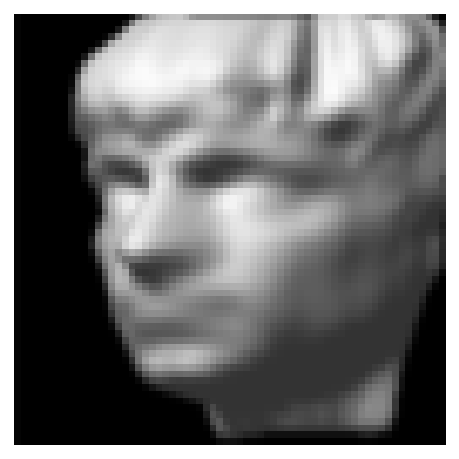

In [9]:
import skimage 
# 加载数据
def load_image_gray(fname): 
    img = skimage.io.imread(fname, plugin="pil")
    return img.astype(np.float64)

face_img = load_image_gray('new_data/face_0000.png') / 65535.0
print(face_img.shape)
ia.show_image_mpl(face_img)

#### 加载数据集
* 将 `face_strip.png` 中的人脸数据加载到单个张量 `faces` 中。
* 将其重新排列为一个 698x64x64 ，然后将其切成每幅图像的每秒*行和列，得到一个 698x32x32 张量的 "数据集"。
* 对其进行正则化
* 使用 `np.loadtxt` 以 2x698 的形式载入文件 `new_data/face_pose_degrees.txt` 并将其转置到 698x2 的数组 `face_poses` 中。

In [10]:
face_strip_load = (load_image_gray(('new_data/face_strip.png')) / 65535.0)
face_strip = face_strip_load.T
print(face_strip.shape)

faces = face_strip.reshape((698,64,64))
faces = faces.swapaxes(1,2)
print(faces.shape)

faces = faces[:,::2,::2]
print(faces.shape)

face_pose_degrees=np.loadtxt("new_data/face_pose_degrees.txt")
face_poses=face_pose_degrees.T

(44672, 64)
(698, 64, 64)
(698, 32, 32)


成功加载后，如下图所示，可以看到一个随机跳动的雕塑头像

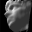

In [11]:
ia.show_gif(faces[0:10,:,:], width="150px")

## 图像输入
现在我们得到了所有图像的矩阵，该矩阵大小为689\*64\*64,但对于$\vec{x}$来说，在随后进行的图像输入中，64\*64并不能很好的进行计算，所以最好的情况是将上述的`faces`转换为698\*1024的矩阵 

In [14]:
face_inputs = faces.reshape(698,1024)
print(face_inputs)

[[0.01617456 0.         0.         ... 0.         0.         0.        ]
 [0.01617456 0.         0.00706493 ... 0.         0.         0.        ]
 [0.01617456 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01617456 0.         0.         ... 0.         0.         0.        ]
 [0.01617456 0.         0.         ... 0.         0.         0.        ]
 [0.01617456 0.         0.         ... 0.         0.         0.        ]]
